<h1 align='center'><b>Машинное обучение в бизнесе<b></h1>

<h1 align='left'>Урок 4. Uplift-моделирование</h1>

<h2 align='center'>Домашняя работа</h2>

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. (опционально) построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install --upgrade pip
# !pip install mplcyberpunk
# !pip install pandas
# !pip install numpy
# !pip install sklearn
# !pip install matplotlib
# !pip install scikit-uplift
# conda install python-graphviz

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier


# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
# import seaborn as sns
import mplcyberpunk

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
# sns.set(font_scale=1.5)
plt.style.use('cyberpunk')

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 42

### 1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [5]:
df = pd.read_csv('./data/HW_data.csv')

df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


### Описание кейса

Context
Marketing Promotion Campaign
with a total of 6,400 customers data.

Content
This dataset show customer's brief information,
historical use of discount or BOGO(Buy One Get One) promotion,
offer has been made, and the conversion result(buy or not).
The conversion average value = $25
Acknowledgements
This dataset is a fictional dataset for practicing purpose

Inspiration
Predict customer's conversion rate
Uplift Modelling to maximizing marketing campaign and reducing campaign cost

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


### 2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [7]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [8]:
df.rename(columns= {'conversion' : 'target',  'offer' : 'treatment'}, inplace=True)
df['treatment'] = df['treatment'].map({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1})
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [9]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

### 3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [10]:
#разделим данные на train/test
indices_learn, indices_valid = train_test_split(df.index, test_size=0.2, random_state=RANDOM_STATE)

### 4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

Познакомимся с датасетомпоближе

In [11]:
df['recency'].value_counts()

1     8952
10    7565
2     7537
9     6441
3     5904
4     5077
6     4605
5     4510
7     4078
11    3504
8     3495
12    2332
Name: recency, dtype: int64

In [12]:
df['history'].value_counts()

29.99      7947
53.79         9
81.20         9
33.18         8
44.14         8
           ... 
433.13        1
196.43        1
1108.21       1
1025.31       1
552.94        1
Name: history, Length: 34833, dtype: int64

In [13]:
df['used_discount'].value_counts()

1    35266
0    28734
Name: used_discount, dtype: int64

In [14]:
df['used_bogo'].value_counts()

1    35182
0    28818
Name: used_bogo, dtype: int64

In [15]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [16]:
df['is_referral'].value_counts()

1    32144
0    31856
Name: is_referral, dtype: int64

In [17]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [18]:
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [19]:
df['target'].value_counts()

0    54606
1     9394
Name: target, dtype: int64

In [20]:
cat_columns = ['zip_code', 'channel']
feature_num_names = ['recency', 'history']

In [21]:
one_hot = pd.get_dummies(df[cat_columns])
df = df.drop(cat_columns, axis=1)
df = df.join(one_hot)

In [22]:
df['treatment'] = df['treatment'].astype('int64').fillna(0)

In [23]:
scaler = StandardScaler()

df_norm = df.copy()
df[feature_num_names] = scaler.fit_transform(df_norm[feature_num_names])

In [24]:
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,1.207751,-0.389003,1,0,0,1,0,0,1,0,0,1,0
1,0.067359,0.339614,1,1,1,0,0,1,0,0,0,0,1
2,0.352457,-0.239836,0,1,1,1,0,0,1,0,0,0,1
3,0.922653,1.693278,1,0,1,1,0,1,0,0,0,0,1
4,-1.073034,-0.768068,1,0,0,1,0,0,0,1,0,0,1


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   recency               64000 non-null  float64
 1   history               64000 non-null  float64
 2   used_discount         64000 non-null  int64  
 3   used_bogo             64000 non-null  int64  
 4   is_referral           64000 non-null  int64  
 5   treatment             64000 non-null  int64  
 6   target                64000 non-null  int64  
 7   zip_code_Rural        64000 non-null  uint8  
 8   zip_code_Surburban    64000 non-null  uint8  
 9   zip_code_Urban        64000 non-null  uint8  
 10  channel_Multichannel  64000 non-null  uint8  
 11  channel_Phone         64000 non-null  uint8  
 12  channel_Web           64000 non-null  uint8  
dtypes: float64(2), int64(5), uint8(6)
memory usage: 3.8 MB


### 5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

Заведем переменные

In [26]:
X_train = df.loc[indices_learn, :].drop(["treatment", "target"] , axis=1)
y_train = df.loc[indices_learn, 'target']
treat_train = df.loc[indices_learn, 'treatment']

X_val = df.loc[indices_valid, :].drop(["treatment", "target"] , axis=1)
y_val = df.loc[indices_valid, 'target']
treat_val = df.loc[indices_valid, 'treatment']

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%': [],
    'uplift@10%': []
}

In [27]:
X_train.head()

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
43820,-0.502837,-0.051124,0,1,0,0,1,0,0,0,1
36500,1.492850,-0.435186,0,1,1,0,1,0,0,0,1
38039,0.922653,-0.827992,0,1,0,1,0,0,0,0,1
1954,-1.073034,-0.224455,0,1,1,0,0,1,0,0,1
28361,0.922653,-0.568502,1,0,0,0,1,0,0,1,0


### Способ №1: одна модель с признаком коммуникации (SoloModel)

uplift@10%: 0.0695
uplift@20%: 0.1060
uplift@30%: 0.0938


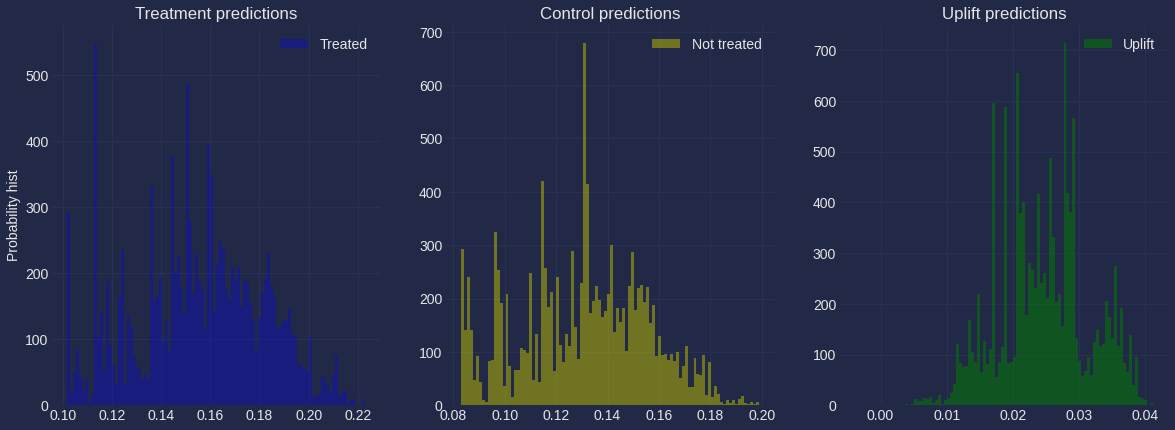

In [28]:
sm = SoloModel(RandomForestClassifier(n_estimators=50, max_depth=3, random_state=RANDOM_STATE, n_jobs=-1))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)
models_results['uplift@30%'].append(sm_score_30)

print(f'uplift@10%: {sm_score_10:.4f}')
print(f'uplift@20%: {sm_score_20:.4f}')
print(f'uplift@30%: {sm_score_30:.4f}')

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Посмотрим на топ-признаки

In [29]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_in_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,0.222197
1,recency,0.217750
2,history,0.215516
3,treatment,0.181351
4,used_bogo,0.051286
5,channel_Phone,0.035183
6,zip_code_Rural,0.034291
7,channel_Web,0.022834
8,used_discount,0.012467
9,channel_Multichannel,0.003460


### Способ №2: модель с трансформацией таргета (ClassTransformation)

In [30]:
ct = ClassTransformation(RandomForestClassifier(n_estimators=50, max_depth=3, random_state=RANDOM_STATE, n_jobs=-1))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score_10)
models_results['uplift@30%'].append(ct_score_20)
models_results['uplift@30%'].append(ct_score_30)

print(f'uplift@10%: {ct_score_10:.4f}')
print(f'uplift@20%: {ct_score_20:.4f}')
print(f'uplift@30%: {ct_score_30:.4f}')

uplift@10%: 0.1369
uplift@20%: 0.1157
uplift@30%: 0.1023


### Способ №3: две независимые моделями (TwoModels)

uplift@10%: 0.1247
uplift@20%: 0.0959
uplift@30%: 0.0940


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

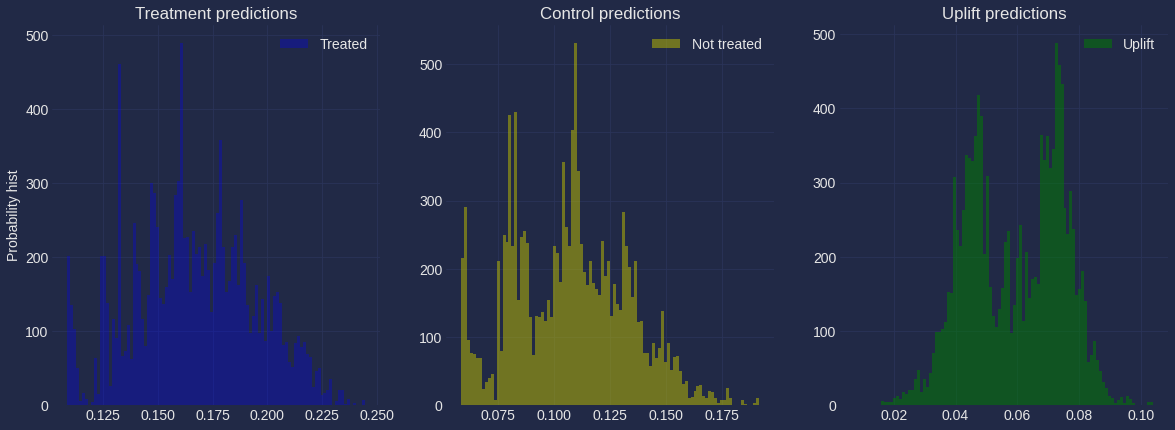

In [31]:
tm = TwoModels(
    estimator_trmnt=RandomForestClassifier(n_estimators=50, max_depth=3, random_state=RANDOM_STATE, n_jobs=-1),
    estimator_ctrl=RandomForestClassifier(n_estimators=50, max_depth=3, random_state=RANDOM_STATE, n_jobs=-1),
    method='vanilla'
)

tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score_30 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)
models_results['uplift@30%'].append(tm_score_30)

print(f'uplift@10%: {tm_score_10:.4f}')
print(f'uplift@20%: {tm_score_20:.4f}')
print(f'uplift@30%: {tm_score_30:.4f}')

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

### 6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [32]:
united_table = pd.DataFrame({
    'approach':['SoloModel', 'ClassTransformation', 'TwoModels'],
    'uplift@10%': [sm_score_10, ct_score_10, tm_score_10],
    'uplift@20%': [sm_score_20, ct_score_20, tm_score_20],
    # 'uplift@30%': [sm_score_30, ct_score_30, tm_score_30]
})

united_table

,approach,uplift@10%,uplift@20%
0,SoloModel,0.069486,0.105963
1,ClassTransformation,0.136896,0.115658
2,TwoModels,0.124692,0.095939


### 7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [33]:
features = [col for col in X_train]

In [34]:
# !git clone https://github.com/uber/causalml
# %cd causalml
# !pip install -r requirements.txt
# !python setup.py build_ext --inplace
# !python setup.py install

Failed to import duecredit due to No module named 'duecredit'


CPU times: user 1.79 s, sys: 100 ms, total: 1.89 s
Wall time: 1.99 s


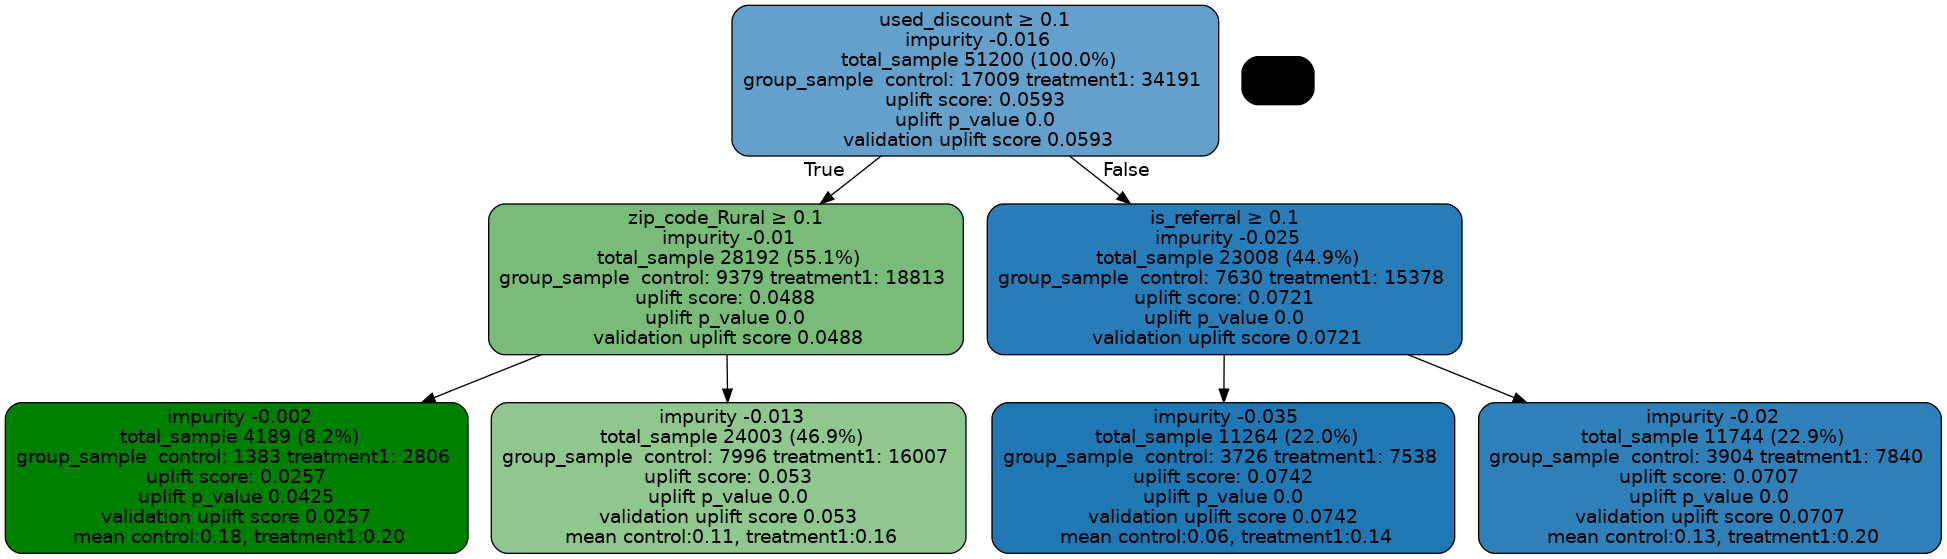

In [35]:
%%time

from IPython.display import Image

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=3, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

### 8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion

### 1) сделать прогноз и получить uplift для тестовой выборки 

In [36]:
sm = SoloModel(RandomForestClassifier(n_estimators=50, max_depth=3, random_state=RANDOM_STATE, n_jobs=-1))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

uplift_sm

array([0.0170546 , 0.03537817, 0.03473506, ..., 0.02055134, 0.02954305,
       0.02490223])

### 2) отсортировать тестовую выборку по uplift по убыванию 

In [37]:
X_val_sort = X_val.assign(uplift_sm=uplift_sm).sort_values(by='uplift_sm', ascending=False)
X_val_sort.head(5)

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,uplift_sm
29159,-1.073034,-0.163984,0,1,1,0,0,1,0,1,0,0.041179
36377,-1.073034,-0.235815,0,1,1,0,1,0,0,1,0,0.040915
29560,-1.073034,-0.300971,0,1,1,0,1,0,0,1,0,0.040915
48484,-1.358132,-0.089225,1,1,1,0,1,0,1,0,0,0.040775
56458,-1.073034,-0.174017,0,1,1,0,0,1,0,0,1,0.040561


### 3) разбить на децили (pandas qcut вам в помощь) 

In [38]:
X_val_sort['decile'] = pd.qcut(X_val_sort['uplift_sm'], q=10)
X_val_sort['decile']

29159      (0.0346, 0.0412]
36377      (0.0346, 0.0412]
29560      (0.0346, 0.0412]
48484      (0.0346, 0.0412]
56458      (0.0346, 0.0412]
                ...        
27587    (-0.00491, 0.0157]
17731    (-0.00491, 0.0157]
50023    (-0.00491, 0.0157]
12214    (-0.00491, 0.0157]
62663    (-0.00491, 0.0157]
Name: decile, Length: 12800, dtype: category
Categories (10, interval[float64, right]): [(-0.00491, 0.0157] < (0.0157, 0.0188] < (0.0188, 0.0208] < (0.0208, 0.0227] ... (0.0266, 0.0283] < (0.0283, 0.0295] < (0.0295, 0.0346] < (0.0346, 0.0412]]

### 4) для каждого дециля посчитать среднюю conversion

In [39]:
uplift_target = X_val_sort.join(y_val).groupby(by=['decile'])['target'].mean()
uplift_target

decile
(-0.00491, 0.0157]    0.136293
(0.0157, 0.0188]      0.120546
(0.0188, 0.0208]      0.122892
(0.0208, 0.0227]      0.140172
(0.0227, 0.0247]      0.138173
(0.0247, 0.0266]      0.153725
(0.0266, 0.0283]      0.116711
(0.0283, 0.0295]      0.152236
(0.0295, 0.0346]      0.199384
(0.0346, 0.0412]      0.180016
Name: target, dtype: float64